# Catégorisez automatiquement des questions

projet : https://openclassrooms.com/fr/paths/148/projects/111/assignment
        
données : https://data.stackexchange.com/stackoverflow/query

### Description du projet
##### Objectifs
- Permettre la prédiction de tags 
- Exposer une API permettant l'interaction avec les models

#### Moyens
- ML non supervisé
- ML supervisé

#### Livrables
- Traitement de pre processing 
- Modèles
- Rapport
- API dont l'entrypoint est exposé sur le net
- Ouvrir le gestionnaire de conf

# Imports

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime


from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk
import nltk.data
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import string
from langdetect import detect
import re
import spacy
from spacy.symbols import ORTH, NORM
from langdetect import detect_langs
import langid
from bs4 import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)


# Dataset

Le dataset est constitué par aggrégation du résultat de tirs successifs par tranches de 250 000 items (id non continu !) de la requête suivante :


select title,body,tags
from posts
where tags is not null 
and id > 750000
and id < 1000000;

L'aggrégation est automatisée par le shell ./dataset/generated_csv/aggregate.sh

In [3]:
#data = pd.read_csv('./dataset/dataset.csv',sep=",",nrows=1000)
data = pd.read_csv('./dataset/dataset.csv',sep=",",nrows=300000)


In [4]:
data.head()

,title,body,tags
0,IEnumerable Or Enumerable for Enumerating composite objects,"<p>Hello I need some help with the following:</p>\n\n<p>I have a ListView control with many ListViewItems, and each ListViewItem's tag property references a domain object like Customer etc.</p>\n\n<p>when retrieving the collection of selected listviewItems, I would like to pass an <code>IEnumerable&lt;Customer&gt;</code> instead of the <code>IEnumerable&lt;ListViewItem&gt;</code> to a function to do something with it.</p>\n\n<p>what would be the best way to achieve this with only one loop?</p>\n\n<p>Thanks.</p>\n",<c#>
1,How to programmatically edit the routing table,"<p>I am writing a daemon running on an embedded platform that needs to change the default route of the device according to which interface it is connecting on at a given time. How can I do this programatically? I know I can use system(""route del default &amp;&amp; route add default gateway blah""); etc but is there a more direct way?</p>\n\n<p>UPDATE: I solved my particular problem by discovering a patch to pppd that allows a replacedefaultroute option. The patch also includes code for programmatically modifying the routing table. It is included in this gentoo bug report <a href=""http://bugs.gentoo.org/227321"" rel=""nofollow noreferrer"">http://bugs.gentoo.org/227321</a></p>\n",<c><linux><networking>
2,How to erase the content on a graphics in GDI+?,"<p>I am using gdi+, in c++.</p>\n\n<pre><code>Bitmap canvasImg = new Bitmap(400, 300, PixelFormat32bppARGB);\nGraphics canvas = new Graphics(&amp;canvasImg );\n\ncanvas.DrawImage(XXXX);\n</code></pre>\n\n<p>There are two problems.\n<p>\n1. I find the canvasImg is black. How can I change the color to white? I mean I want an white canvas. <p>\n2. If I have drawn some thing on the canvas, How can I clear the canvas?<p></p>\n\n<p>Many Thanks!</p>\n",<canvas><gdi+>
3,How do I access the state of individual bits of a word in MIPS?,<p>I'm writing a program and I need to determine if bits 3 and 6 are set. I know that I can rotate a word or left/right shift it.</p>\n\n<p>But how do I access individual bit's state? Do I use a bitwise operator like and/xor?</p>\n,<assembly><bit-manipulation><mips>
4,How to handle a closing application event in Java?,"<p>Having a console application, a server accepting several connections from clients, is it possible to have a listener or an event on a closing application? I want, in this event, tell all connected clients to gently disconnect before the application really closes itself.</p>\n\n<p>Any solution? Thank you!</p>\n",<java><events><listener>


# Constats

Dans l'objectif de faire du NLP nous pouvons déjà dégager des éléments remarquables qui vont conduire notre pré-traitement du dataset : 

- a priori beaucoup de question sont rédigées en anglais
    - il faudra faire un choix pour le corpus en fonction de la langue prépondérante et écarter les enregistrements qui ne sont pas rédigés dans cette langue
- le body et la liste de tags associée sont au format html
    - il faudra prétraiter les colonnes pour revenir à un format dépollué
    - on mettra également de côté les sauts de ligne (\n)
    - prévoir de tout passer en minuscules
- on constate que le body peut contenir des éléments qui ne vont pas directement servir pour le nlp:
    - des extraits de code cadrés par les balises html '\<code\>\</code\>' et '\<pre\>\</pre\>'
    - des liens hypertexte cadrés par les balises html '\<a href\>\</a\>'

Par ailleurs on procèdera à une normalisation par lemmatisation, basée sur le corpus de la langue principale retenue.

Les fonctions suivantes vont servir à effectuer les opérations élémentaires de prétraitement.

Elles seront reprises dans un pipeline complet pour permettre leur enchainement automatique.


In [3]:
def logIt(caller,s):
    dt = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
    show_log = f'{caller: <16} ' + s
    print(dt + ' - ' + show_log)

In [5]:
"""
-----------------------------------------------------------------
Desc:   Detect lang
Input:  Dataset
Output: languages representativeness  

Traitements appliqués : 
- detection langue
-----------------------------------------------------------------
"""
def langRepresentativeness(df, caller):
    
    langs = {}

    logIt(caller,'Get lang from title')
    
    for title in df['title']:
        lang, log_prob = langid.classify(title)
        #print(lang + ' : ' + title)
        
        test = langs.get(lang)
        if test:
            langs[lang] += 1
        else:
            langs[lang] = 1   
    
    logIt(caller,'=> done')
    
    logIt(caller,'Plot representativeness')

    plt.bar(range(len(langs)), list(langs.values()), align='center')
    plt.xticks(range(len(langs)), list(langs.keys()))

    plt.show()    
    

2021-04-18 15:39:25 - test             Get lang from title
2021-04-18 15:39:27 - test             => done
2021-04-18 15:39:27 - test             Plot representativeness


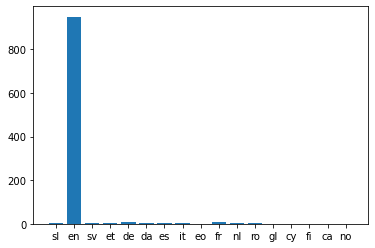

In [6]:
langRepresentativeness(data, 'test')

# Pre-processing

## Langue
L'anglais est la langue majoritaire. On ne va garder que les enregistrements en anglais pour définir un corpus cohérent.

In [4]:
"""
-----------------------------------------------------------------
Desc:   Only keep english records 
Input:  Dataset
Output: only english records dataset  

Traitements appliqués : 
- create new feature with language
- remove all records where title language is not english
-----------------------------------------------------------------
"""
def removeNonEngRecords(df,caller):
    
    language = []
    for title in data['title']:
        lang, log_prob = langid.classify(title)
        #print(lang)
        language.append(lang)
    
    df['lang'] = language
    
    df.drop(df[df.lang != "en"].index, inplace=True)
    df.drop(['lang'], inplace=True, axis=1)
    
    return df

In [5]:
data = removeNonEngRecords(data,'test')

In [6]:
data.head()

,title,body,tags
1,How to programmatically edit the routing table,"<p>I am writing a daemon running on an embedded platform that needs to change the default route of the device according to which interface it is connecting on at a given time. How can I do this programatically? I know I can use system(""route del default &amp;&amp; route add default gateway blah""); etc but is there a more direct way?</p>\n\n<p>UPDATE: I solved my particular problem by discovering a patch to pppd that allows a replacedefaultroute option. The patch also includes code for programmatically modifying the routing table. It is included in this gentoo bug report <a href=""http://bugs.gentoo.org/227321"" rel=""nofollow noreferrer"">http://bugs.gentoo.org/227321</a></p>\n",<c><linux><networking>
2,How to erase the content on a graphics in GDI+?,"<p>I am using gdi+, in c++.</p>\n\n<pre><code>Bitmap canvasImg = new Bitmap(400, 300, PixelFormat32bppARGB);\nGraphics canvas = new Graphics(&amp;canvasImg );\n\ncanvas.DrawImage(XXXX);\n</code></pre>\n\n<p>There are two problems.\n<p>\n1. I find the canvasImg is black. How can I change the color to white? I mean I want an white canvas. <p>\n2. If I have drawn some thing on the canvas, How can I clear the canvas?<p></p>\n\n<p>Many Thanks!</p>\n",<canvas><gdi+>
3,How do I access the state of individual bits of a word in MIPS?,<p>I'm writing a program and I need to determine if bits 3 and 6 are set. I know that I can rotate a word or left/right shift it.</p>\n\n<p>But how do I access individual bit's state? Do I use a bitwise operator like and/xor?</p>\n,<assembly><bit-manipulation><mips>
4,How to handle a closing application event in Java?,"<p>Having a console application, a server accepting several connections from clients, is it possible to have a listener or an event on a closing application? I want, in this event, tell all connected clients to gently disconnect before the application really closes itself.</p>\n\n<p>Any solution? Thank you!</p>\n",<java><events><listener>
5,Reading file contents on the client-side in javascript in various browsers,"<p>I'm attempting to provide a script-only solution for reading the contents of a file on a client machine through a browser.</p>\n\n<p>I have a solution that works with Firefox and Internet Explorer. It's not pretty, but I'm only trying things at the moment:</p>\n\n<pre><code>function getFileContents() {\n var fileForUpload = document.forms[0].fileForUpload;\n var fileName = fileForUpload.value;\n\n if (fileForUpload.files) {\n var fileContents = fileForUpload.files.item(0).getAsBinary();\n document.forms[0].fileContents.innerHTML = fileContents;\n } else {\n // try the IE method\n var fileContents = ieReadFile(fileName);\n document.forms[0].fileContents.innerHTML = fileContents;\n }\n} \n\nfunction ieReadFile(filename) \n{\n try\n {\n var fso = new ActiveXObject(""Scripting.FileSystemObject""); \n var fh = fso.OpenTextFile(filename, 1); \n var contents = fh.ReadAll(); \n fh.Close();\n return contents;\n }\n catch (Exception)\n {\n return ""Cannot open file :("";\n }\n}\n</code></pre>\n\n<p>I can call <code>getFileContents()</code> and it will write the contents into the <code>fileContents</code> text area.</p>\n\n<p><strong>Is there a way to do this in other browsers?</strong></p>\n\n<p>I'm most concerned with Safari and Chrome at the moment, but I'm open to suggestions for any other browser.</p>\n\n<p><strong>Edit:</strong> In response to the question, ""Why do you want to do this?"":</p>\n\n<p>Basically, I want to hash the file contents together with a one-time-password on the client side so I can send this information back as a verification.</p>\n",<javascript><html><file-io><sandbox>


## Merge des colonnes title et body

La colonne titre comporte du texte qui peut présenter un intérêt dans la caractérisation du post et l'attribution des tags liés au sujet. On merge son contenu dans la colonne du body.

In [7]:
"""
-----------------------------------------------------------------
Desc:   Merge des colonnes title et body
Input:  Dataset
Output: dataset with body feature merged with title   

Traitements appliqués : 
- remove 
- create new column with extracted text
- 
-----------------------------------------------------------------
"""
def mergeTitle(df, caller):
    
    
    df['final_body'] = df["title"] + ' ' + df["body"]
    df.drop(['body'], inplace=True, axis=1)
    df.columns = ['title','tags','body']
    
    return df

In [8]:
data = mergeTitle(data,'test')

In [9]:
data.head()

,title,tags,body
1,How to programmatically edit the routing table,<c><linux><networking>,"How to programmatically edit the routing table <p>I am writing a daemon running on an embedded platform that needs to change the default route of the device according to which interface it is connecting on at a given time. How can I do this programatically? I know I can use system(""route del default &amp;&amp; route add default gateway blah""); etc but is there a more direct way?</p>\n\n<p>UPDATE: I solved my particular problem by discovering a patch to pppd that allows a replacedefaultroute option. The patch also includes code for programmatically modifying the routing table. It is included in this gentoo bug report <a href=""http://bugs.gentoo.org/227321"" rel=""nofollow noreferrer"">http://bugs.gentoo.org/227321</a></p>\n"
2,How to erase the content on a graphics in GDI+?,<canvas><gdi+>,"How to erase the content on a graphics in GDI+? <p>I am using gdi+, in c++.</p>\n\n<pre><code>Bitmap canvasImg = new Bitmap(400, 300, PixelFormat32bppARGB);\nGraphics canvas = new Graphics(&amp;canvasImg );\n\ncanvas.DrawImage(XXXX);\n</code></pre>\n\n<p>There are two problems.\n<p>\n1. I find the canvasImg is black. How can I change the color to white? I mean I want an white canvas. <p>\n2. If I have drawn some thing on the canvas, How can I clear the canvas?<p></p>\n\n<p>Many Thanks!</p>\n"
3,How do I access the state of individual bits of a word in MIPS?,<assembly><bit-manipulation><mips>,How do I access the state of individual bits of a word in MIPS? <p>I'm writing a program and I need to determine if bits 3 and 6 are set. I know that I can rotate a word or left/right shift it.</p>\n\n<p>But how do I access individual bit's state? Do I use a bitwise operator like and/xor?</p>\n
4,How to handle a closing application event in Java?,<java><events><listener>,"How to handle a closing application event in Java? <p>Having a console application, a server accepting several connections from clients, is it possible to have a listener or an event on a closing application? I want, in this event, tell all connected clients to gently disconnect before the application really closes itself.</p>\n\n<p>Any solution? Thank you!</p>\n"
5,Reading file contents on the client-side in javascript in various browsers,<javascript><html><file-io><sandbox>,"Reading file contents on the client-side in javascript in various browsers <p>I'm attempting to provide a script-only solution for reading the contents of a file on a client machine through a browser.</p>\n\n<p>I have a solution that works with Firefox and Internet Explorer. It's not pretty, but I'm only trying things at the moment:</p>\n\n<pre><code>function getFileContents() {\n var fileForUpload = document.forms[0].fileForUpload;\n var fileName = fileForUpload.value;\n\n if (fileForUpload.files) {\n var fileContents = fileForUpload.files.item(0).getAsBinary();\n document.forms[0].fileContents.innerHTML = fileContents;\n } else {\n // try the IE method\n var fileContents = ieReadFile(fileName);\n document.forms[0].fileContents.innerHTML = fileContents;\n }\n} \n\nfunction ieReadFile(filename) \n{\n try\n {\n var fso = new ActiveXObject(""Scripting.FileSystemObject""); \n var fh = fso.OpenTextFile(filename, 1); \n var contents = fh.ReadAll(); \n fh.Close();\n return contents;\n }\n catch (Exception)\n {\n return ""Cannot open file :("";\n }\n}\n</code></pre>\n\n<p>I can call <code>getFileContents()</code> and it will write the contents into the <code>fileContents</code> text area.</p>\n\n<p><strong>Is there a way to do this in other browsers?</strong></p>\n\n<p>I'm most concerned with Safari and Chrome at the moment, but I'm open to suggestions for any other browser.</p>\n\n<p><strong>Edit:</strong> In response to the question, ""Why do you want to do this?"":</p>\n\n<p>Basically, I want to hash the file contents together with a one-time-password on the client side so I can send this information back as a verification.</p>

## Traitement du HTML

In [10]:
"""
-----------------------------------------------------------------
Desc:   Extract text from questions body 
Input:  Dataset
Output: dataset with body feature without tags   

Traitements appliqués : 
- extract text from tags contents
- create new column with extracted text
- 
-----------------------------------------------------------------
"""
def extractText(df, caller):
    bodies = []
    for body in data['body']: 
        #print(body)
        soup = BeautifulSoup(body)    
        tags = [tag.name for tag in soup.find_all()]
        #print(tags)
        #loop tag to remove code and href tags
        if "pre" in tags:
            soup.pre.decompose()
        if "code" in tags:
            try:
                soup.code.decompose()
            except:
                pass
        if "a" in tags:
            soup.a.decompose()
        bodies.append(soup.get_text())
        
    df['final_body'] = bodies
    df.drop(['body'], inplace=True, axis=1)
    df.columns = ['title', 'tags','body']
    
    return df
    

In [11]:
data = extractText(data, 'test')

In [12]:
data.head()

,title,tags,body
1,How to programmatically edit the routing table,<c><linux><networking>,"How to programmatically edit the routing table I am writing a daemon running on an embedded platform that needs to change the default route of the device according to which interface it is connecting on at a given time. How can I do this programatically? I know I can use system(""route del default && route add default gateway blah""); etc but is there a more direct way?\nUPDATE: I solved my particular problem by discovering a patch to pppd that allows a replacedefaultroute option. The patch also includes code for programmatically modifying the routing table. It is included in this gentoo bug report \n"
2,How to erase the content on a graphics in GDI+?,<canvas><gdi+>,"How to erase the content on a graphics in GDI+? I am using gdi+, in c++.\n\nThere are two problems.\n\n1. I find the canvasImg is black. How can I change the color to white? I mean I want an white canvas. \n2. If I have drawn some thing on the canvas, How can I clear the canvas?\nMany Thanks!\n"
3,How do I access the state of individual bits of a word in MIPS?,<assembly><bit-manipulation><mips>,How do I access the state of individual bits of a word in MIPS? I'm writing a program and I need to determine if bits 3 and 6 are set. I know that I can rotate a word or left/right shift it.\nBut how do I access individual bit's state? Do I use a bitwise operator like and/xor?\n
4,How to handle a closing application event in Java?,<java><events><listener>,"How to handle a closing application event in Java? Having a console application, a server accepting several connections from clients, is it possible to have a listener or an event on a closing application? I want, in this event, tell all connected clients to gently disconnect before the application really closes itself.\nAny solution? Thank you!\n"
5,Reading file contents on the client-side in javascript in various browsers,<javascript><html><file-io><sandbox>,"Reading file contents on the client-side in javascript in various browsers I'm attempting to provide a script-only solution for reading the contents of a file on a client machine through a browser.\nI have a solution that works with Firefox and Internet Explorer. It's not pretty, but I'm only trying things at the moment:\n\nI can call and it will write the contents into the fileContents text area.\nIs there a way to do this in other browsers?\nI'm most concerned with Safari and Chrome at the moment, but I'm open to suggestions for any other browser.\nEdit: In response to the question, ""Why do you want to do this?"":\nBasically, I want to hash the file contents together with a one-time-password on the client side so I can send this information back as a verification.\n"


## Traitement des caractères spéciaux

### Suppression des sauts de ligne

In [13]:
"""
-----------------------------------------------------------------
Desc:   Remove \n 
Input:  Dataset
Output: dataset with body feature without useless characters   

Traitements appliqués : 
- remove 
- create new column with extracted text
- 
-----------------------------------------------------------------
"""
def removeLineFeed(df, caller):
    bodies = []
    for body in data['body']: 
        final_body = body.replace('\n',' ')
        bodies.append(final_body)

    df['final_body'] = bodies
    df.drop(['body'], inplace=True, axis=1)
    df.columns = ['title', 'tags','body']
    
    return df
    

In [14]:
data = removeLineFeed(data,'test')

In [15]:
data.head()

,title,tags,body
1,How to programmatically edit the routing table,<c><linux><networking>,"How to programmatically edit the routing table I am writing a daemon running on an embedded platform that needs to change the default route of the device according to which interface it is connecting on at a given time. How can I do this programatically? I know I can use system(""route del default && route add default gateway blah""); etc but is there a more direct way? UPDATE: I solved my particular problem by discovering a patch to pppd that allows a replacedefaultroute option. The patch also includes code for programmatically modifying the routing table. It is included in this gentoo bug report"
2,How to erase the content on a graphics in GDI+?,<canvas><gdi+>,"How to erase the content on a graphics in GDI+? I am using gdi+, in c++. There are two problems. 1. I find the canvasImg is black. How can I change the color to white? I mean I want an white canvas. 2. If I have drawn some thing on the canvas, How can I clear the canvas? Many Thanks!"
3,How do I access the state of individual bits of a word in MIPS?,<assembly><bit-manipulation><mips>,How do I access the state of individual bits of a word in MIPS? I'm writing a program and I need to determine if bits 3 and 6 are set. I know that I can rotate a word or left/right shift it. But how do I access individual bit's state? Do I use a bitwise operator like and/xor?
4,How to handle a closing application event in Java?,<java><events><listener>,"How to handle a closing application event in Java? Having a console application, a server accepting several connections from clients, is it possible to have a listener or an event on a closing application? I want, in this event, tell all connected clients to gently disconnect before the application really closes itself. Any solution? Thank you!"
5,Reading file contents on the client-side in javascript in various browsers,<javascript><html><file-io><sandbox>,"Reading file contents on the client-side in javascript in various browsers I'm attempting to provide a script-only solution for reading the contents of a file on a client machine through a browser. I have a solution that works with Firefox and Internet Explorer. It's not pretty, but I'm only trying things at the moment: I can call and it will write the contents into the fileContents text area. Is there a way to do this in other browsers? I'm most concerned with Safari and Chrome at the moment, but I'm open to suggestions for any other browser. Edit: In response to the question, ""Why do you want to do this?"": Basically, I want to hash the file contents together with a one-time-password on the client side so I can send this information back as a verification."


### Suppression des caractères spéciaux

On supprime les caractères qui n'apporte pas de sens :

-   ponctuation
-   caractères spéciaux à l'exclusion du + qui est une occurrence importante pour identifier certains langages informatiques
-   les chiffres

In [16]:
"""
-----------------------------------------------------------------
Desc:   Remove useless characters 
Input:  Dataset
Output: dataset with body feature without useless characters   

Traitements appliqués : 
- remove 
- create new column with extracted text
- 
-----------------------------------------------------------------
"""
def removeUselessChars(df, caller):
    bodies = []
    
    pattern = re.compile('[^A-Za-z +]')

    for body in data['body']: 
        final_body = pattern.sub(' ',body)        
        final_body = re.sub(pattern, ' ', body)
        bodies.append(final_body)

    df['final_body'] = bodies
    df.drop(['body'], inplace=True, axis=1)
    df.columns = ['title', 'tags','body']
    
    return df
    

In [17]:
data = removeUselessChars(data,'test')

In [18]:
data.head()

,title,tags,body
1,How to programmatically edit the routing table,<c><linux><networking>,How to programmatically edit the routing table I am writing a daemon running on an embedded platform that needs to change the default route of the device according to which interface it is connecting on at a given time How can I do this programatically I know I can use system route del default route add default gateway blah etc but is there a more direct way UPDATE I solved my particular problem by discovering a patch to pppd that allows a replacedefaultroute option The patch also includes code for programmatically modifying the routing table It is included in this gentoo bug report
2,How to erase the content on a graphics in GDI+?,<canvas><gdi+>,How to erase the content on a graphics in GDI+ I am using gdi+ in c++ There are two problems I find the canvasImg is black How can I change the color to white I mean I want an white canvas If I have drawn some thing on the canvas How can I clear the canvas Many Thanks
3,How do I access the state of individual bits of a word in MIPS?,<assembly><bit-manipulation><mips>,How do I access the state of individual bits of a word in MIPS I m writing a program and I need to determine if bits and are set I know that I can rotate a word or left right shift it But how do I access individual bit s state Do I use a bitwise operator like and xor
4,How to handle a closing application event in Java?,<java><events><listener>,How to handle a closing application event in Java Having a console application a server accepting several connections from clients is it possible to have a listener or an event on a closing application I want in this event tell all connected clients to gently disconnect before the application really closes itself Any solution Thank you
5,Reading file contents on the client-side in javascript in various browsers,<javascript><html><file-io><sandbox>,Reading file contents on the client side in javascript in various browsers I m attempting to provide a script only solution for reading the contents of a file on a client machine through a browser I have a solution that works with Firefox and Internet Explorer It s not pretty but I m only trying things at the moment I can call and it will write the contents into the fileContents text area Is there a way to do this in other browsers I m most concerned with Safari and Chrome at the moment but I m open to suggestions for any other browser Edit In response to the question Why do you want to do this Basically I want to hash the file contents together with a one time password on the client side so I can send this information back as a verification


### Lower 

On passe tout en minuscules

In [19]:
"""
-----------------------------------------------------------------
Desc:   toLowerCase 
Input:  Dataset
Output: dataset with body feature to lower case   

Traitements appliqués : 
- remove 
- create new column with extracted text
- 
-----------------------------------------------------------------
"""
def toLowerCase(df, caller):
    bodies = []
    
    for body in data['body']: 
        final_body = body.lower()
        bodies.append(final_body)

    df['final_body'] = bodies
    df.drop(['body'], inplace=True, axis=1)
    df.columns = ['title', 'tags','body']
    
    return df

In [20]:
data = toLowerCase(data,'test')

In [21]:
data.head()

,title,tags,body
1,How to programmatically edit the routing table,<c><linux><networking>,how to programmatically edit the routing table i am writing a daemon running on an embedded platform that needs to change the default route of the device according to which interface it is connecting on at a given time how can i do this programatically i know i can use system route del default route add default gateway blah etc but is there a more direct way update i solved my particular problem by discovering a patch to pppd that allows a replacedefaultroute option the patch also includes code for programmatically modifying the routing table it is included in this gentoo bug report
2,How to erase the content on a graphics in GDI+?,<canvas><gdi+>,how to erase the content on a graphics in gdi+ i am using gdi+ in c++ there are two problems i find the canvasimg is black how can i change the color to white i mean i want an white canvas if i have drawn some thing on the canvas how can i clear the canvas many thanks
3,How do I access the state of individual bits of a word in MIPS?,<assembly><bit-manipulation><mips>,how do i access the state of individual bits of a word in mips i m writing a program and i need to determine if bits and are set i know that i can rotate a word or left right shift it but how do i access individual bit s state do i use a bitwise operator like and xor
4,How to handle a closing application event in Java?,<java><events><listener>,how to handle a closing application event in java having a console application a server accepting several connections from clients is it possible to have a listener or an event on a closing application i want in this event tell all connected clients to gently disconnect before the application really closes itself any solution thank you
5,Reading file contents on the client-side in javascript in various browsers,<javascript><html><file-io><sandbox>,reading file contents on the client side in javascript in various browsers i m attempting to provide a script only solution for reading the contents of a file on a client machine through a browser i have a solution that works with firefox and internet explorer it s not pretty but i m only trying things at the moment i can call and it will write the contents into the filecontents text area is there a way to do this in other browsers i m most concerned with safari and chrome at the moment but i m open to suggestions for any other browser edit in response to the question why do you want to do this basically i want to hash the file contents together with a one time password on the client side so i can send this information back as a verification


### Traitement des stopwords

In [22]:
"""
-----------------------------------------------------------------
Desc:   unitary stopwords removal function 
Input:  text
Output: text without stopwords   

Traitements appliqués : 
- stop words removal 
-----------------------------------------------------------------
"""
def remove_stopwords(text):
    stop_words = set(stopwords.words('english')) 
    #print(text)
    word_tokens = word_tokenize(text) 

    filtered_text = ' '.join(w for w in word_tokens if not w in stop_words)
   
    return filtered_text
    

In [23]:
"""
-----------------------------------------------------------------
Desc:   Suppress stopwords, english corpus 
Input:  Dataset
Output: dataset with body feature without stopwords   

Traitements appliqués : 
- remove 
- create new column with extracted text
- 
-----------------------------------------------------------------
"""
def removeStopwords(df, caller):
    bodies = []

    df['no_stop_words'] = df.body.apply(remove_stopwords)    

    df.drop(['body'], inplace=True, axis=1)
    df.columns = ['title', 'tags','body']
    
    return df
  


In [24]:
data = removeStopwords(data,'test')

In [25]:
data.head()

,title,tags,body
1,How to programmatically edit the routing table,<c><linux><networking>,programmatically edit routing table writing daemon running embedded platform needs change default route device according interface connecting given time programatically know use system route del default route add default gateway blah etc direct way update solved particular problem discovering patch pppd allows replacedefaultroute option patch also includes code programmatically modifying routing table included gentoo bug report
2,How to erase the content on a graphics in GDI+?,<canvas><gdi+>,erase content graphics gdi+ using gdi+ c++ two problems find canvasimg black change color white mean want white canvas drawn thing canvas clear canvas many thanks
3,How do I access the state of individual bits of a word in MIPS?,<assembly><bit-manipulation><mips>,access state individual bits word mips writing program need determine bits set know rotate word left right shift access individual bit state use bitwise operator like xor
4,How to handle a closing application event in Java?,<java><events><listener>,handle closing application event java console application server accepting several connections clients possible listener event closing application want event tell connected clients gently disconnect application really closes solution thank
5,Reading file contents on the client-side in javascript in various browsers,<javascript><html><file-io><sandbox>,reading file contents client side javascript various browsers attempting provide script solution reading contents file client machine browser solution works firefox internet explorer pretty trying things moment call write contents filecontents text area way browsers concerned safari chrome moment open suggestions browser edit response question want basically want hash file contents together one time password client side send information back verification


### Lemmatization vs Stemming

Pour constituer un ensemble homogène non inutilement redondant on va appliquer une méthode de normalisation. Nous avons le choix entre : 

- Stemming 
    - Troncage du terme vers sa racine la plus significative par identification de préfixes et/ou suffixes probables
    - Ex: studies --> studi
- Lemmatization
    - Mutation du terme vers sa forme sémantique la plus significative
    - Ex: studies --> study

Pour notre projet nous allons retenir la lemmatisation

In [26]:
"""
-----------------------------------------------------------------
Desc:   unitary Lemmatization 
Input:  text
Output: lemmatized text   

Traitements appliqués : 
- lemmatization 
-----------------------------------------------------------------
"""
def lemmatize_text(text):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [27]:
"""
-----------------------------------------------------------------
Desc:   Lemmatization 
Input:  Dataset
Output: dataset with body feature normalized by lemmatization   

Traitements appliqués : 
- remove 
- create new column with extracted text
- 
-----------------------------------------------------------------
"""
def lemmatize(df, caller):
    bodies = []

    df['text_lemmatized'] = df.body.apply(lemmatize_text)    

    df.drop(['body'], inplace=True, axis=1)
    df.columns = ['title', 'tags','body']
    
    return df

In [28]:
data = lemmatize(data,'test')

In [29]:
data.head()

,title,tags,body
1,How to programmatically edit the routing table,<c><linux><networking>,"[programmatically, edit, routing, table, writing, daemon, running, embedded, platform, need, change, default, route, device, according, interface, connecting, given, time, programatically, know, use, system, route, del, default, route, add, default, gateway, blah, etc, direct, way, update, solved, particular, problem, discovering, patch, pppd, allows, replacedefaultroute, option, patch, also, includes, code, programmatically, modifying, routing, table, included, gentoo, bug, report]"
2,How to erase the content on a graphics in GDI+?,<canvas><gdi+>,"[erase, content, graphic, gdi+, using, gdi+, c++, two, problem, find, canvasimg, black, change, color, white, mean, want, white, canvas, drawn, thing, canvas, clear, canvas, many, thanks]"
3,How do I access the state of individual bits of a word in MIPS?,<assembly><bit-manipulation><mips>,"[access, state, individual, bit, word, mips, writing, program, need, determine, bit, set, know, rotate, word, left, right, shift, access, individual, bit, state, use, bitwise, operator, like, xor]"
4,How to handle a closing application event in Java?,<java><events><listener>,"[handle, closing, application, event, java, console, application, server, accepting, several, connection, client, possible, listener, event, closing, application, want, event, tell, connected, client, gently, disconnect, application, really, close, solution, thank]"
5,Reading file contents on the client-side in javascript in various browsers,<javascript><html><file-io><sandbox>,"[reading, file, content, client, side, javascript, various, browser, attempting, provide, script, solution, reading, content, file, client, machine, browser, solution, work, firefox, internet, explorer, pretty, trying, thing, moment, call, write, content, filecontents, text, area, way, browser, concerned, safari, chrome, moment, open, suggestion, browser, edit, response, question, want, basically, want, hash, file, content, together, one, time, password, client, side, send, information, back, verification]"


### Traitement de la colonne tags

On veut avoir une colonne contenant une liste de tags nettoyée de ses caractères < et > résultant du format de stockage en base

In [30]:
"""
-----------------------------------------------------------------
Desc:   normalize tags column 
Input:  Dataset
Output: dataset with tags feature ready to be used   

Traitements appliqués : 
- remove 
- create new column with extracted text
- 
-----------------------------------------------------------------
"""
def setupTags(df, caller):
    tags = []
    
    for tag in data['tags']: 
        final_tags = tag.replace('<',',')
        final_tags = final_tags.replace('>','')
        final_tags = final_tags[1:]
        
        tags.append(final_tags)

    df['final_tags'] = tags
    df.drop(['tags'], inplace=True, axis=1)
    df.columns = ['title', 'body', 'tags']
    
    return df

In [31]:
data = setupTags(data,'test')

In [32]:
data.head()

,title,body,tags
1,How to programmatically edit the routing table,"[programmatically, edit, routing, table, writing, daemon, running, embedded, platform, need, change, default, route, device, according, interface, connecting, given, time, programatically, know, use, system, route, del, default, route, add, default, gateway, blah, etc, direct, way, update, solved, particular, problem, discovering, patch, pppd, allows, replacedefaultroute, option, patch, also, includes, code, programmatically, modifying, routing, table, included, gentoo, bug, report]","c,linux,networking"
2,How to erase the content on a graphics in GDI+?,"[erase, content, graphic, gdi+, using, gdi+, c++, two, problem, find, canvasimg, black, change, color, white, mean, want, white, canvas, drawn, thing, canvas, clear, canvas, many, thanks]","canvas,gdi+"
3,How do I access the state of individual bits of a word in MIPS?,"[access, state, individual, bit, word, mips, writing, program, need, determine, bit, set, know, rotate, word, left, right, shift, access, individual, bit, state, use, bitwise, operator, like, xor]","assembly,bit-manipulation,mips"
4,How to handle a closing application event in Java?,"[handle, closing, application, event, java, console, application, server, accepting, several, connection, client, possible, listener, event, closing, application, want, event, tell, connected, client, gently, disconnect, application, really, close, solution, thank]","java,events,listener"
5,Reading file contents on the client-side in javascript in various browsers,"[reading, file, content, client, side, javascript, various, browser, attempting, provide, script, solution, reading, content, file, client, machine, browser, solution, work, firefox, internet, explorer, pretty, trying, thing, moment, call, write, content, filecontents, text, area, way, browser, concerned, safari, chrome, moment, open, suggestion, browser, edit, response, question, want, basically, want, hash, file, content, together, one, time, password, client, side, send, information, back, verification]","javascript,html,file-io,sandbox"


### Traitement des duplicates

On supprime les mots dupliqués dans le contenu du body

In [35]:
"""
-----------------------------------------------------------------
Desc:   normalize tags column 
Input:  Dataset
Output: dataset with tags feature ready to be used   

Traitements appliqués : 
- remove 
- create new column with extracted text
- 
-----------------------------------------------------------------
"""
def dropDuplicates(df, caller):
    bodies = []
    
    for body in data['body']: 
        final_body = list(set(body))
        
        bodies.append(final_body)

    df['final_tags'] = bodies
    df.drop(['body'], inplace=True, axis=1)
    df.columns = ['title', 'tags','body']
    
    return df

In [36]:
data = dropDuplicates(data,'test')

In [37]:
data.head()

,title,tags,body
1,How to programmatically edit the routing table,"c,linux,networking","[add, problem, daemon, writing, route, according, time, need, given, gateway, etc, use, know, allows, routing, pppd, programmatically, report, solved, option, modifying, gentoo, device, interface, connecting, default, discovering, direct, change, programatically, embedded, also, way, replacedefaultroute, del, blah, update, code, bug, patch, system, running, edit, includes, included, particular, platform, table]"
2,How to erase the content on a graphics in GDI+?,"canvas,gdi+","[problem, two, using, erase, gdi+, white, graphic, black, thanks, color, content, mean, canvas, thing, canvasimg, change, want, many, drawn, c++, clear, find]"
3,How do I access the state of individual bits of a word in MIPS?,"assembly,bit-manipulation,mips","[shift, writing, left, need, right, state, use, know, program, mips, xor, bit, individual, determine, rotate, set, bitwise, operator, like, word, access]"
4,How to handle a closing application event in Java?,"java,events,listener","[closing, listener, tell, event, application, console, client, accepting, java, really, solution, disconnect, gently, thank, want, connection, connected, several, handle, server, possible, close]"
5,Reading file contents on the client-side in javascript in various browsers,"javascript,html,file-io,sandbox","[file, provide, hash, text, firefox, call, one, time, internet, verification, javascript, write, basically, send, safari, password, concerned, content, suggestion, back, client, pretty, information, area, machine, thing, together, solution, explorer, filecontents, moment, attempting, way, want, browser, trying, script, various, chrome, question, work, open, edit, side, reading, response]"


# Analyse exploratoire

## Word Cloud

In [41]:
count_keyword = dict()
for index, col in data['body'].iteritems():
    #for s in col.split(','):
    for s in col:
        if s in count_keyword.keys():
            count_keyword[s] += 1
        else:
            count_keyword[s] = 1

keyword_census = []
for k,v in count_keyword.items():
    keyword_census.append([k,v])
keyword_census.sort(key = lambda x:x[1], reverse = True)

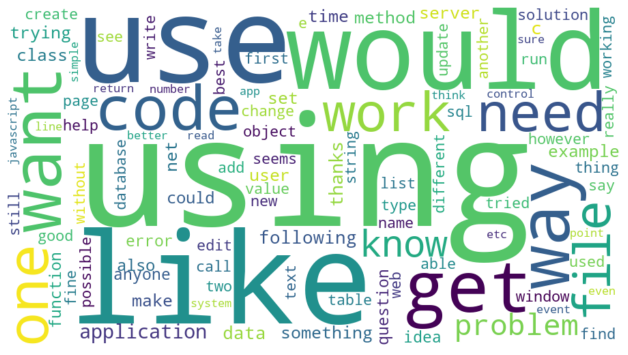

In [42]:
fig = plt.figure(1, figsize=(11,9))
ax1 = fig.add_subplot(1,1,1)
words = dict()
trunc_occurences = keyword_census[0:100]
for s in trunc_occurences:
    words[s[0]] = s[1]

wordcloud = WordCloud(width=900,height=500, background_color='white', 
                      max_words=1628,relative_scaling=0.6,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
plt.show()

## Metriques

In [45]:
data_analysis = pd.read_csv('./dataset/dataset.csv',sep=",",nrows=1000)

### Distribution du nombre de tags par question

Text(0, 0.5, 'Nb. Questions')

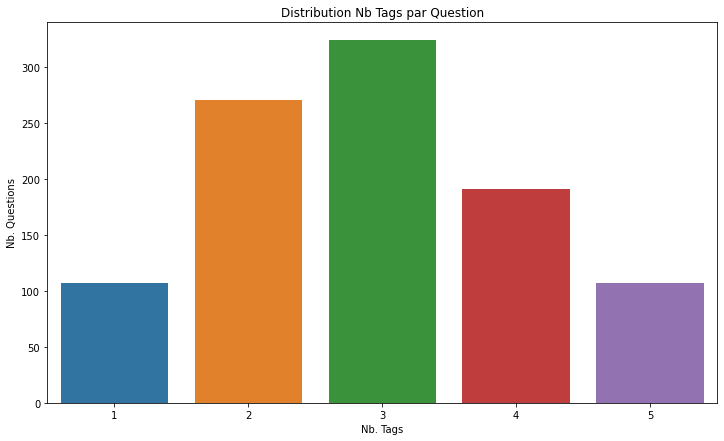

In [48]:
def apply_nb_tags(str_tags):
    return len(re.findall(r'(?<=\<)[^\<\>]+(?=\>)', str_tags))

data_analysis["nb_tags"] = data_analysis["tags"].apply(apply_nb_tags)

fig = plt.figure(figsize=(12, 7))
plt.title("Distribution Nb Tags par Question")
ax = sns.countplot(data=data_analysis, x="nb_tags")
ax.set_xlabel("Nb. Tags")
ax.set_ylabel("Nb. Questions")

### Fréquence d'utilisation des tags

#### Liste des tags

In [51]:
list_tags_raw=[]
for idx in range(0, data_analysis.shape[0]):
    #print("start...",idx)
    list_tags_raw = list_tags_raw+(re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           data_analysis.iloc[idx].tags))
# list of unique tags over all questions (no limitation at most frequent tags)
list_unique_tags = list(np.unique(list_tags_raw)) 
print('Total Number of Tags:', len(list_tags_raw))
print("Number of Unique Tags:",len(list_unique_tags))
list_unique_tags[:10]

Total Number of Tags: 2920
Number of Unique Tags: 1058


['.emf',
 '.htaccess',
 '.net',
 '.net-3.5',
 '32-bit',
 '3d',
 '3dcamera',
 '64-bit',
 'ab-testing',
 'abstract-class']

#### Top 10

In [52]:
df_tags = pd.DataFrame(list_tags_raw, columns=["Tag"])
df_tags = pd.DataFrame(df_tags.Tag.value_counts())
df_tags.head(10)

,Tag
c#,161
.net,80
java,73
javascript,68
asp.net,55
c++,46
sql-server,45
php,43
sql,42
jquery,42


#### Distribution

Text(0, 0.5, "Occurrences d'apparition")

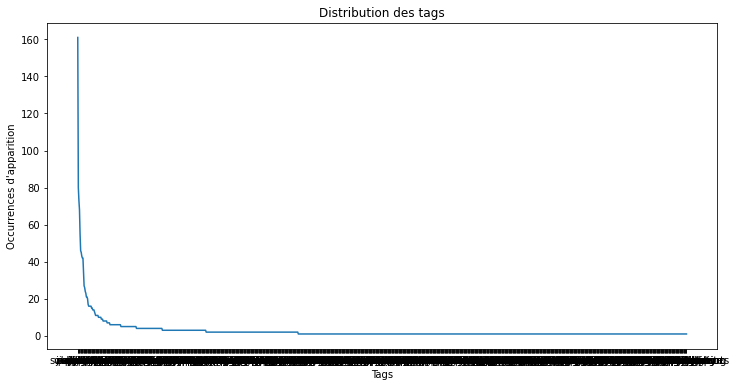

In [62]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution des tags")
plt.plot(df_tags)
plt.xlabel("Tags")
plt.ylabel("Occurrences d'apparition")

In [69]:
list_nb_tags_used_min = [160, 100, 60, 40, 15]

list_list_most_used =[]
list_nb_tags_unique_most_used = []
list_pc_tags =[]
for nb_tags_used_min in list_nb_tags_used_min:
    
    list_list_most_used.append(list(df_tags[df_tags["Tag"] >= \
                                            nb_tags_used_min].index))
    list_nb_tags_unique_most_used.append(
        df_tags[df_tags["Tag"]>=nb_tags_used_min].shape[0])
    
    list_pc_tags.append(100*df_tags[df_tags["Tag"]>=nb_tags_used_min].\
                 shape[0]/df_tags.shape[0])
    
    print('Nb Tags utilisés < {} fois : {} sur {} Tags [{:.2f}%]'.\
          format(nb_tags_used_min,
                 df_tags[df_tags["Tag"]<nb_tags_used_min].shape[0], 
                 df_tags.shape[0],
                 100*df_tags[df_tags["Tag"]<nb_tags_used_min].\
                 shape[0]/df_tags.shape[0]))

    print('Nb Tags utilisés >= {} fois : {} sur {} Tags [{:.2f}%]'.\
          format(nb_tags_used_min,
                 df_tags[df_tags["Tag"]>=nb_tags_used_min].shape[0], 
                 df_tags.shape[0],
                 100*df_tags[df_tags["Tag"]>=nb_tags_used_min].\
                 shape[0]/df_tags.shape[0]))

df_most = pd.DataFrame(data=list_nb_tags_used_min, columns=["nb_min_used"])
df_most["nb_most_used_tags"] = list_nb_tags_unique_most_used
df_most["percent_of_unique_tags"] = list_pc_tags
df_most

Nb Tags utilisés < 160 fois : 1057 sur 1058 Tags [99.91%]
Nb Tags utilisés >= 160 fois : 1 sur 1058 Tags [0.09%]
Nb Tags utilisés < 100 fois : 1057 sur 1058 Tags [99.91%]
Nb Tags utilisés >= 100 fois : 1 sur 1058 Tags [0.09%]
Nb Tags utilisés < 60 fois : 1054 sur 1058 Tags [99.62%]
Nb Tags utilisés >= 60 fois : 4 sur 1058 Tags [0.38%]
Nb Tags utilisés < 40 fois : 1048 sur 1058 Tags [99.05%]
Nb Tags utilisés >= 40 fois : 10 sur 1058 Tags [0.95%]
Nb Tags utilisés < 15 fois : 1032 sur 1058 Tags [97.54%]
Nb Tags utilisés >= 15 fois : 26 sur 1058 Tags [2.46%]


,nb_min_used,nb_most_used_tags,percent_of_unique_tags
0,160,1,0.094518
1,100,1,0.094518
2,60,4,0.378072
3,40,10,0.945180
4,15,26,2.457467


Text(0, 0.5, "Nombre d'utilisation maximum")

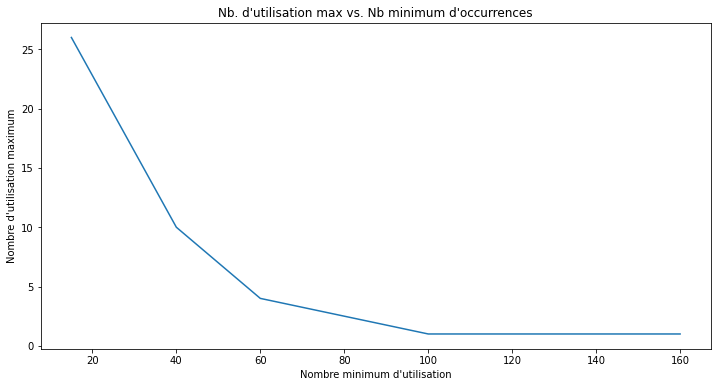

In [78]:
fig = plt.figure(figsize=(12, 6))
plt.title("Nb. d'utilisation max vs. Nb minimum d'occurrences")
plt.plot(df_most["nb_min_used"],df_most["nb_most_used_tags"])
plt.xlabel("Nombre minimum d'utilisation")
plt.ylabel("Nombre d'utilisation maximum")

### Distribution du nombre de lemma par question

Text(0, 0.5, 'Nb. Questions')

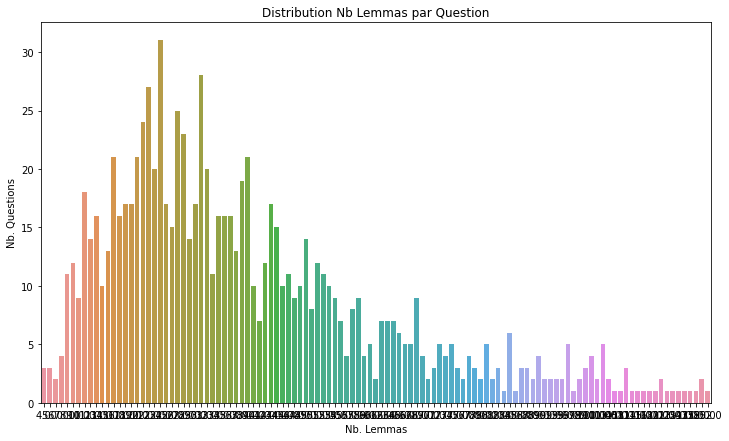

In [79]:
def apply_nb_lemmas(s):
    return len(s)

data_analysis["nb_lemmas"] = data["body"].apply(apply_nb_lemmas)

fig = plt.figure(figsize=(12, 7))
plt.title("Distribution Nb Lemmas par Question")
ax = sns.countplot(data=data_analysis, x="nb_lemmas")
ax.set_xlabel("Nb. Lemmas")
ax.set_ylabel("Nb. Questions")

<AxesSubplot:title={'center':'Boxplot distribution lemmas'}>

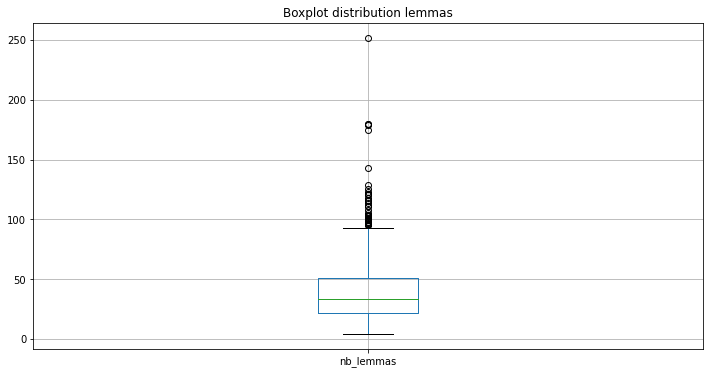

In [85]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot distribution lemmas")
data_analysis.boxplot(column=['nb_lemmas'])

# Snapshot du dataset

In [ ]:
data.drop(['title'], inplace=True, axis=1)

In [ ]:
data.to_csv('./dataset/preprocessed_dataset.csv', index=False)